# Analyzing CITE-seq data

**Authors:** Isaac Virshup, Alex Wolf

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl

In [2]:
sc.logging.print_version_and_date()
sc.logging.print_versions()
sc.set_figure_params(frameon=False, figsize=(3, 3))

Running Scanpy 1.4.5.post3.dev3+g9d647a1, on 2020-03-18 12:09.
scanpy==1.4.5.post3.dev3+g9d647a1 anndata==0.7.1 umap==0.3.10 numpy==1.16.3 scipy==1.3.0 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1


## Reading

In [2]:
# !mkdir -p data
# !wget http://cf.10xgenomics.com/samples/cell-exp/3.1.0/5k_pbmc_protein_v3_nextgem/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5 -O data/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5

In [3]:
datafile = "data/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5"

In [4]:
pbmc = sc.read_10x_h5(datafile, gex_only=False)
pbmc

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 5527 × 33570 
    var: 'gene_ids', 'feature_types', 'genome'

## Preprocessing

Split into protein and gene modalities and create two `AnnData` objects:

In [5]:
protein = pbmc[:, pbmc.var["genome"] == ""].copy()
genes = pbmc[:, pbmc.var["genome"] != ""].copy()

genes.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Let us first visualize the protein counts.

### Protein

In [6]:
protein.var["control"] = protein.var_names.str.contains("control")

In [7]:
sc.pp.calculate_qc_metrics(
    protein,
    percent_top=(5, 10, 15),
    var_type="antibodies",
    qc_vars=("control",),
    inplace=True,
)

 We can look at qc stuff:

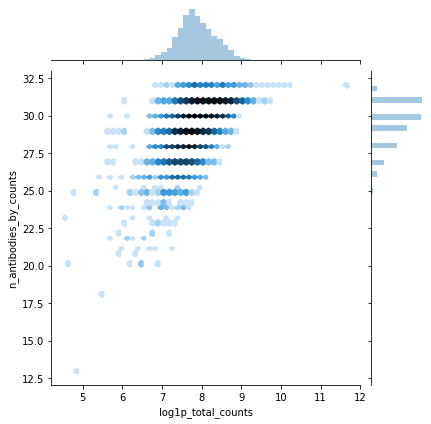

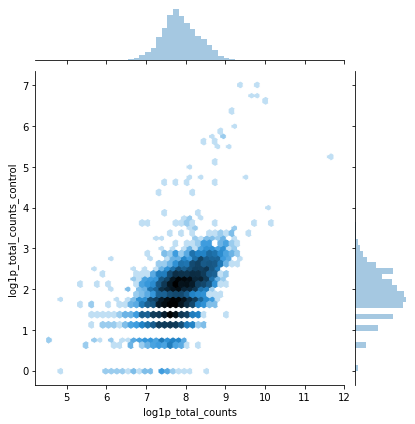

In [8]:
sns.jointplot("log1p_total_counts", "n_antibodies_by_counts", protein.obs, kind="hex", norm=mpl.colors.LogNorm())
sns.jointplot("log1p_total_counts", "log1p_total_counts_control", protein.obs, kind="hex", norm=mpl.colors.LogNorm())

In [9]:
protein.layers["counts"] = protein.X.copy()

In [10]:
sc.pp.normalize_geometric(protein)
sc.pp.log1p(protein)

In [11]:
sc.pp.pca(protein, n_comps=20)
sc.pp.neighbors(protein, use_rep="X", metric="cosine")  # There's only 32 antibodies, so might as well
sc.tl.umap(protein)
sc.tl.leiden(protein)

/Users/isaac/github/scanpy/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp['distances'], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/Users/isaac/github/scanpy/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp['connectivities'], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/Users/isaac/github/scanpy/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp['connectivities'], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),
/Users/isaac/github/scanpy/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has be

... storing 'feature_types' as categorical
... storing 'genome' as categorical


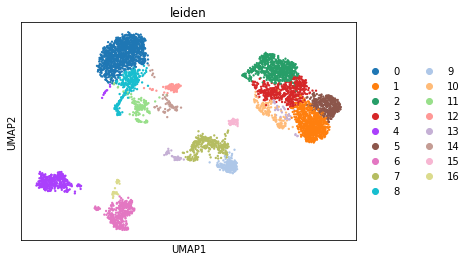

In [12]:
sc.pl.umap(protein, color="leiden")

In [13]:
protein

AnnData object with n_obs × n_vars = 5527 × 32 
    obs: 'n_antibodies_by_counts', 'log1p_n_antibodies_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_5_antibodies', 'pct_counts_in_top_10_antibodies', 'pct_counts_in_top_15_antibodies', 'total_counts_control', 'log1p_total_counts_control', 'pct_counts_control', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'control', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

### RNA

Preprocess

In [14]:
genes.var["mito"] = genes.var_names.str.startswith("MT-")

In [15]:
sc.pp.filter_genes(genes, min_counts=1)
sc.pp.calculate_qc_metrics(genes, qc_vars=["mito"], inplace=True)

In [16]:
# Cache counts
genes.layers["counts"] = genes.X.copy()

In [17]:
sc.pp.normalize_total(genes)
sc.pp.log1p(genes)

In [18]:
sc.pp.pca(genes)
sc.pp.neighbors(genes, n_neighbors=30)
sc.tl.umap(genes)
sc.tl.leiden(genes)

/Users/isaac/github/scanpy/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp['distances'], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/Users/isaac/github/scanpy/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp['connectivities'], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/Users/isaac/github/scanpy/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp['connectivities'], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),
/Users/isaac/github/scanpy/scanpy/tools/_leiden.py:111: FutureWarning: This location for 'connectivities' is deprecated. It has be

## Visualization

In [19]:
genes.obsm["protein"] = protein.to_df()
genes.obsm["protein_umap"] = protein.obsm["X_umap"]
genes.obs["protein_leiden"] = protein.obs["leiden"]

The clusterings disagree quite a bit, so we can tell that we are missing some information:

... storing 'feature_types' as categorical
... storing 'genome' as categorical


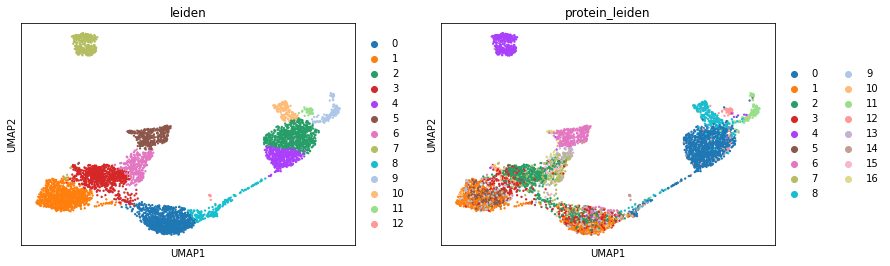

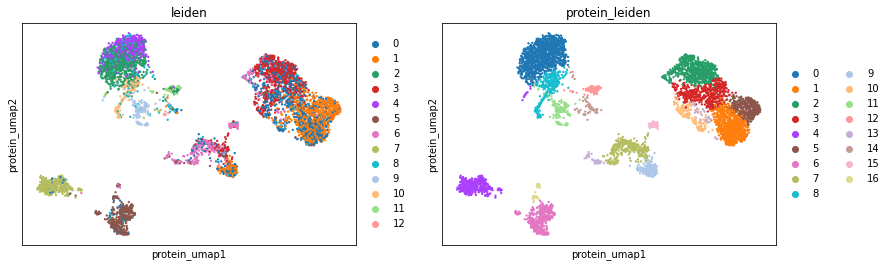

In [20]:
sc.pl.umap(genes, color=["leiden", "protein_leiden"])
sc.pl.embedding(genes, basis="protein_umap", color=["leiden", "protein_leiden"])

### Plotting values between modalities

* TODO: Get selectors like this working in scanpy.

### Imports and helper functions

In [21]:
import altair as alt
from functools import partial

alt.renderers.enable("png")
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [22]:
def embedding_chart(df: pd.DataFrame, coord_pat: str, *, size=5) -> alt.Chart:
    """Make schema for coordinates, like sc.pl.embedding."""
    x, y = df.columns[df.columns.str.contains(coord_pat)]
    return (
        alt.Chart(plotdf, height=300, width=300)
        .mark_circle(size=size)
        .encode(
            x=alt.X(x, axis=None),
            y=alt.Y(y, axis=None),
        )
    )

def umap_chart(df: pd.DataFrame, **kwargs) -> alt.Chart:
    """Like sc.pl.umap, but just the coordinates."""
    return embedding_chart(df, "umap", **kwargs)

def encode_color(c: alt.Chart, col: str, *, qdomain=(0, 1), scheme: str = "lightgreyred") -> alt.Chart:
    """Add colors to an embedding plot schema."""
    base = c.properties(title=col)
    if pd.api.types.is_categorical(c.data[col]):
        return base.encode(color=col)
    else:
        return base.encode(
            color=alt.Color(
                col,
                scale=alt.Scale(
                    scheme=scheme,
                    clamp=True,
                    domain=list(c.data[col].quantile(qdomain)),
                    nice=True,
                )
            )
        )

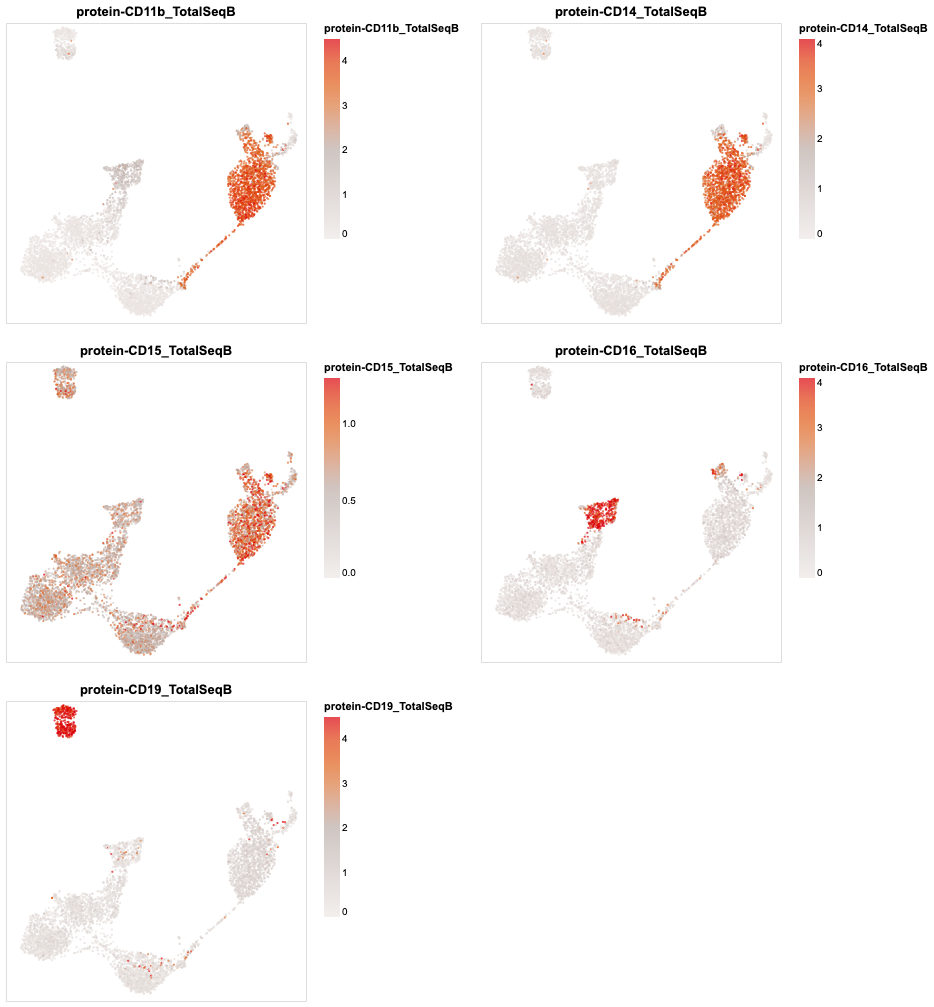

In [23]:
plotdf = sc.get.obs_df(
    genes,
    obsm_keys=[("X_umap", i) for i in range(2)] + [("protein", i) for i in genes.obsm["protein"].columns]
)
c = umap_chart(plotdf)
(
    alt.concat(
        *map(partial(encode_color, c, qdomain=(0, .95)), plotdf.columns[5:10]),
        columns=2
    )
    .resolve_scale(color='independent')
    .configure_axis(grid=False)
)

## Clustering

So far I've only gotten okay results from this, but also haven't followed up on it much:

In [24]:
genes.obsp["protein_connectivities"] = protein.obsp["connectivities"]

In [25]:
sc.tl.leiden_multiplex(genes, ["connectivities", "protein_connectivities"])

As you can see, looks only okay. I think it'd be worth doing some feature selection as well as doublet removal and trying again.

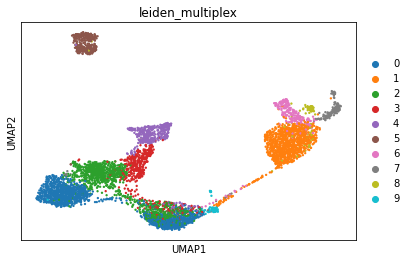

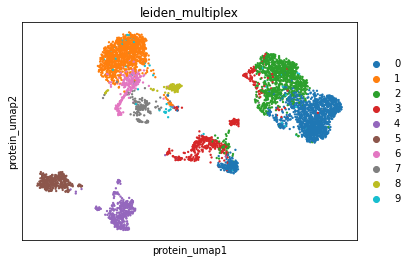

In [26]:
sc.pl.umap(genes, color="leiden_multiplex")
sc.pl.embedding(genes, basis="protein_umap", color="leiden_multiplex")

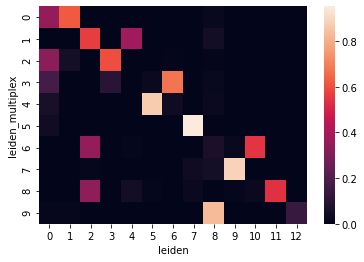

In [27]:
sns.heatmap(pd.crosstab(genes.obs["leiden_multiplex"], genes.obs["leiden"], normalize="index"))

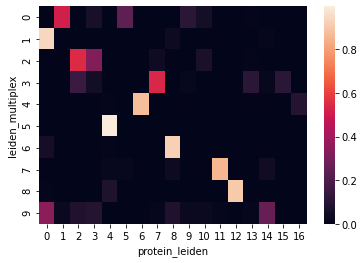

In [28]:
sns.heatmap(pd.crosstab(genes.obs["leiden_multiplex"], genes.obs["protein_leiden"], normalize="index"))